In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
import cv2
from google.colab.patches import cv2_imshow
import time
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist

def show_roi_proposed(img, rects):
  print('Total Number of Region Proposals: {}'.format(len(rects)))
  numShowRects = 100
  imOut = img.copy()
  for i, rect in enumerate(rects):
        x, y, w, h = rect
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  cv2_imshow(imOut)


def get_rects(img, strategy=0):
  """three strategies to choose:
  0.SelectiveSearchQuality: produce more rects(sometimes too much)
  1.SelectiveSearchFast: faster method, less rects
  2.SingleStrategy: Fastest, and has least number of rects(also good quality when we have less noise)
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)

  if strategy==0:
    ss.switchToSelectiveSearchQuality()
  elif strategy==1:
    ss.switchToSelectiveSearchFast()
  else:
    ss.switchToSingleStrategy()

  rects = ss.process()
  return rects

def remove_useless_rects_efficient(rects): 
  rect_f = rects.copy()
  time_start = time.time()
  #get rid of rects too thin
  rects_delete_index = []
  for i in range(rect_f.shape[0]):
    if rect_f[i,2]*1.0/rect_f[i,3] > 10 or rect_f[i,2]*1.0/rect_f[i,3] < 0.1:
      rects_delete_index.append(i)
  rect_f = np.delete(rect_f,rects_delete_index,axis=0)

  #set dimension 3,4 as coordinate of 2nd point in diagonal to facilite the calculate of distance
  rect_f[:,2:] = rect_f[:,2:] + rect_f[:,:2]
  #get rid of rects too close and similar
  rects_delete_index = []
  distance = cdist(rect_f[:,:2], rect_f[:,:2])
  distance_diagonal = np.sqrt(np.sum(rect_f[:,:2]-rect_f[:,2:],axis=1)**2)
  distance_2 = cdist(rect_f[:,2:], rect_f[:,2:])
  for i in range(distance.shape[0]):
    for j in range(i+1, distance.shape[0]):
      #if the rects are too close and similar
      if distance[i,j] < distance_diagonal[i]*0.2 and distance_2[i,j]<distance_diagonal[i]*0.3:
        rect_f[j] = np.array([min(rect_f[i,0],rect_f[j,0]), min(rect_f[i,1],rect_f[j,1]),max(rect_f[i,2],rect_f[j,2]),max(rect_f[i,3],rect_f[j,3])]).flatten()
        rects_delete_index.append(i)
  rect_f = np.delete(rect_f,rects_delete_index,axis=0)
  time_end = time.time()
  print('propcess finished, using {0:.2f}s'.format(time_end-time_start))
  rect_f[:,2:] = rect_f[:,2:] - rect_f[:,:2]
  return rect_f
  

Total Number of Region Proposals: 665


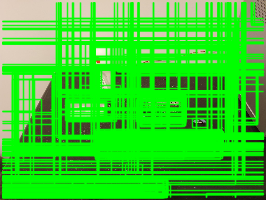

propcess finished, using 0.15s
Total Number of Region Proposals: 57


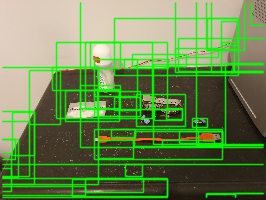

In [91]:
# image_path = '/content/drive/My Drive/image_test.jpg'
# image_path = '/content/drive/My Drive/image_test2.png'
image_path = '/content/test2.jpg'

# read image
newHeight = 200
img = cv2.imread(image_path)
# resize image
newWidth = int(img.shape[1]*newHeight/img.shape[0])
img = cv2.resize(img, (newWidth, newHeight))    
#get and show rects
rects = get_rects(img)
show_roi_proposed(img, rects)
#remove some rects
rects_new = remove_useless_rects_efficient(rects)
show_roi_proposed(img, rects_new)